# 0. Path

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint


Using TensorFlow backend.


# 1. 載入資料

In [2]:
tag_dict = dict([('kitchen', 0),('street', 1),('industrial', 2),('insidecity', 3),('forest', 4),
                 ('livingroom', 5),('opencountry', 6),('PARoffice', 7),('mountain', 8),('CALsuburb', 9),
                 ('coast', 10),('store', 11),('bedroom', 12),('tallbuilding', 13),('highway', 14)])

tag_key = list(tag_dict.keys())

In [3]:
cv_img = np.ndarray(shape=(256,256,3))
file_id = []

for img in glob.glob("/data/examples/may_the_4_be_with_u/where_am_i/testset/*.jpg"):
    c  = cv2.imread(img)
    cr = cv2.resize(c,(256,256))
    cv_img = np.vstack((cv_img,cr))
    file_id.append(img)

cv_img = cv_img.reshape(-1, 256, 256, 3) # -1為:自動調整使四項乘起來與reshape總共乘積一致
cv_img = np.delete(cv_img, (0), axis=0)  # delete 1st item (row)
ar_img_test = cv_img

ar_img_test.astype('float32')
ar_img_test /=255

In [4]:
ar_img = np.ndarray(shape=(1,256,256,3))
ar_tag = np.ndarray(shape=(1))

n=0
for tag in tag_key:

    cv_img = np.ndarray(shape=(256,256,3))
    for img in glob.glob("/data/examples/may_the_4_be_with_u/where_am_i/train/" + tag + "/*.jpg"):
        c  = cv2.imread(img)
        cr = cv2.resize(c,(256,256))
        cv_img = np.vstack((cv_img,cr))
    cv_img = cv_img.reshape(-1, 256, 256, 3) # -1為:自動調整使四項乘起來與reshape總共乘積一致
    
    cv_img = np.delete(cv_img, (0), axis=0) # delete 1st item (row)
    
    n_img = int(len(cv_img))
    print(tag, n, n_img)
        
    im = cv_img
    ta = np.full((n_img,1),n, dtype=np.uint)
    n = n+1
    ar_img = np.vstack((ar_img, im))
    ar_tag = np.vstack((ar_tag, ta))
    
ar_img = np.delete(ar_img, (0), axis=0) # delete 1st item (row)
ar_tag = np.delete(ar_tag, (0), axis=0) # delete 1st item (row)

kitchen 0 110
street 1 192
industrial 2 211
insidecity 3 208
forest 4 228
livingroom 5 189
opencountry 6 310
PARoffice 7 115
mountain 8 274
CALsuburb 9 141
coast 10 260
store 11 215
bedroom 12 116
tallbuilding 13 256
highway 14 160


In [5]:
print("how many photos?                 ", len(ar_img))
print("how many tags?                   ", len(ar_tag), np.asarray(ar_tag[14]).shape)
print("how many images in one group?    ", len(cv_img))
print("--------------------------------------------------------")
print("pixel per image?                 ", cv_img[0].shape)
print("total images, pixels             ", ar_img.shape)

how many photos?                  2985
how many tags?                    2985 (1,)
how many images in one group?     160
--------------------------------------------------------
pixel per image?                  (256, 256, 3)
total images, pixels              (2985, 256, 256, 3)


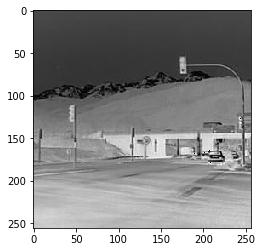

In [6]:
plt.imshow(cv_img[0], cmap="gray")

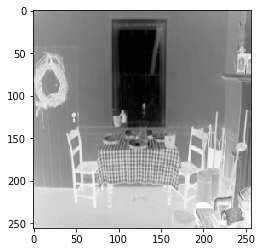

In [17]:
plt.imshow(ar_img[1], cmap="gray")

# Transform data to trainable format

In [8]:
x = ar_img
y = ar_tag

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.02, random_state=6)

# Data Augmentation

In [9]:
datagen = ImageDataGenerator(
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# CNN parameters

In [10]:
batch_size = 40 
num_classes = 15
epochs = 50 # 可以往上調到100
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_CNN_train_model.h5'

# One-hot encoding : Convert vectors to binary

In [11]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

# 3A. build CNN & DNN model

In [12]:
#============================
# CNN
#============================
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=x_train.shape[1:])) # 拿其中一筆讓model知道等等CNN中的shape
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

#============================
# DNN
#============================
model.add(Flatten())
model.add(Dense(512)) # 512
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 254, 128)     73856     
_________________________________________________________________
activation_2 (Activation)    (None, 254, 254, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 128)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 127, 127, 64)      73792     
__________

# 3B. Model Compilation

In [13]:
# initiate Adam optimizer
opt = keras.optimizers.Adam()

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

# 將原始RGB數字(0-255)縮到0-1之間
x_train /= 255.
x_test /= 255.

# 3C. Train CNN model

In [18]:
# ModelCheckpoint to save model / weights (檢查model是否進步，有的話存檔)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=8, verbose=1) # 若五次的training都沒有進步就會停下來

# Fit the model on the batches generated by datagen.flow().
model_history = model.fit_generator(datagen.flow(x_train, y_train,
                                                 batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4,
                                    callbacks=[earlystop]) # 每次train完之後的檢查

Epoch 1/50
74/74 [==============================] - 31s 413ms/step - loss: 0.7861 - acc: 0.7233 - val_loss: 0.8823 - val_acc: 0.7167
Epoch 2/50
74/74 [==============================] - 30s 409ms/step - loss: 0.7846 - acc: 0.7199 - val_loss: 0.9136 - val_acc: 0.6667
Epoch 3/50
74/74 [==============================] - 30s 410ms/step - loss: 0.8072 - acc: 0.7176 - val_loss: 0.9415 - val_acc: 0.6833
Epoch 4/50
74/74 [==============================] - 30s 411ms/step - loss: 0.7725 - acc: 0.7274 - val_loss: 0.8600 - val_acc: 0.6500
Epoch 5/50
74/74 [==============================] - 30s 411ms/step - loss: 0.7965 - acc: 0.7229 - val_loss: 0.8492 - val_acc: 0.6833
Epoch 6/50
74/74 [==============================] - 30s 411ms/step - loss: 0.7569 - acc: 0.7335 - val_loss: 0.8908 - val_acc: 0.6833
Epoch 7/50
74/74 [==============================] - 30s 411ms/step - loss: 0.7726 - acc: 0.7132 - val_loss: 0.9444 - val_acc: 0.6833
Epoch 8/50
74/74 [==============================] - 30s 410ms/step - 

In [19]:
y_pred = model.predict_classes(ar_img_test,batch_size=1) # 每次train完之後的檢查

In [20]:
KaggleSubmission = pd.DataFrame({ 'id':    file_id,
                                  'class': y_pred })
KaggleSubmission.to_csv("KaggleSubmission_midterm2_new.csv", index=False)

# 3D. Load Model & Score

In [18]:
# loading our save model
print("Loading trained model")
model = load_model(model_path)

# Score trained model
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Loading trained model


OSError: Unable to open file (unable to open file: name = '/home/jovyan/saved_models/keras_CNN_train_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# 4. Plot the Score

In [ ]:
training_loss = model_history.history['loss']
val_loss      = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss,      label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()